In [4]:
# 1. Imports and Setup
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px
import plotly.graph_objects as go

# Set plot style
sns.set(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial']  # For Chinese characters
plt.rcParams['axes.unicode_minus'] = False

# Add parent dir to path to access app modules if needed
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
print("Libraries imported successfully")

Libraries imported successfully


In [5]:
# 2. Load Data from SQLite
# Assuming notebook is running in backend/notebooks/, db is in backend/pharma.db
db_path = '../pharma.db'
if not os.path.exists(db_path):
    print(f"Database not found at {db_path}")
else:
    # Connect to database
    engine = create_engine(f'sqlite:///{db_path}')
    
    # Query RFM data
    query = "SELECT npi, recency_days, frequency, monetary FROM doctors"
    df = pd.read_sql(query, engine)
    
    print(f"Data loaded: {df.shape[0]} doctors")
    print("Head:")
    print(df.head())
    print("\nStatistics:")
    print(df.describe().round(2))

Data loaded: 738772 doctors
Head:
          npi  recency_days  frequency  monetary
0  1821102930           215          4  69793.02
1  1760577639           215          5   7532.97
2  1114114279           199         96   2652.43
3  1336200351           206         11    219.24
4  1366576423           203         59   1310.51

Statistics:
       recency_days  frequency     monetary
count     738772.00  738772.00    738772.00
mean         280.43      15.82      3377.92
std           96.50      32.98    126761.55
min          181.00       1.00         0.33
25%          202.00       1.00        52.35
50%          242.00       4.00       173.92
75%          335.00      14.00       648.62
max          546.00    1147.00  91082706.03


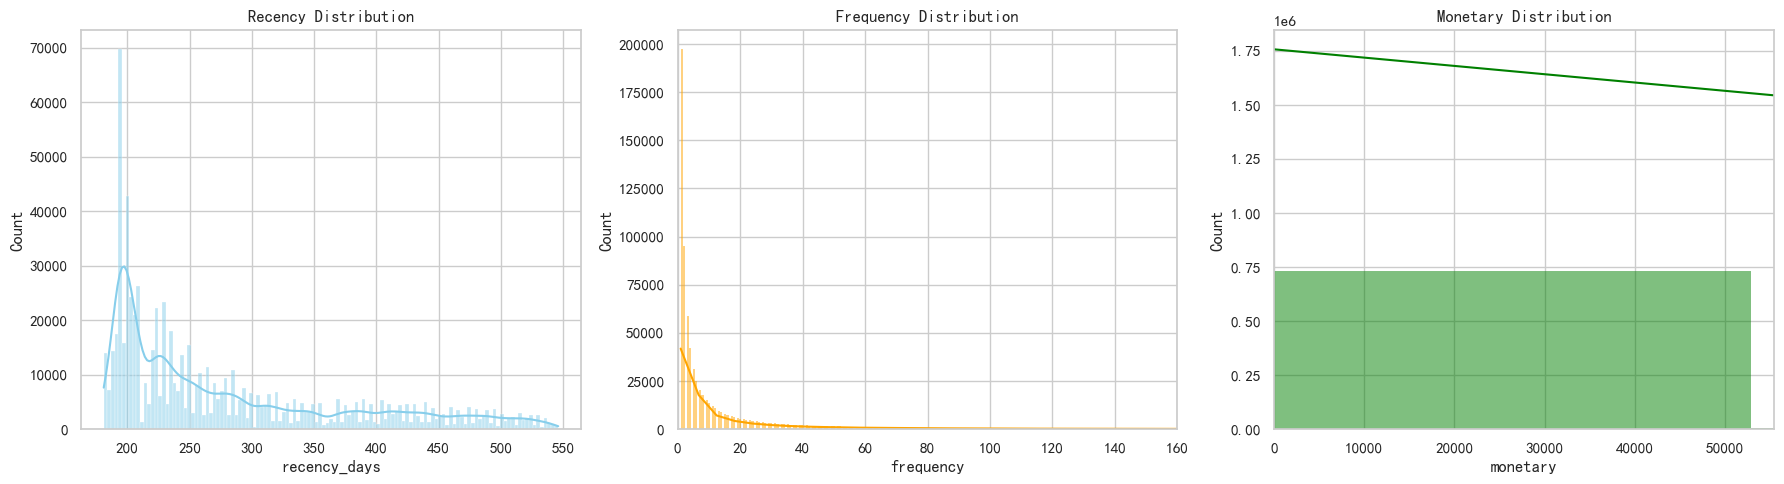

Skewness:
recency_days      1.065222
frequency         5.520733
monetary        538.798310
dtype: float64


In [6]:
# 3. Data Exploration & Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recency
sns.histplot(df['recency_days'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Recency Distribution')

# Frequency (Log scale often better for visualization due to long tail)
sns.histplot(df['frequency'], kde=True, ax=axes[1], color='orange')
axes[1].set_title('Frequency Distribution')
axes[1].set_xlim(0, df['frequency'].quantile(0.99)) # Show 99% of data

# Monetary
sns.histplot(df['monetary'], kde=True, ax=axes[2], color='green')
axes[2].set_title('Monetary Distribution')
axes[2].set_xlim(0, df['monetary'].quantile(0.99))

plt.tight_layout()
plt.show()

# Skewness check
print("Skewness:")
print(df[['recency_days', 'frequency', 'monetary']].skew())

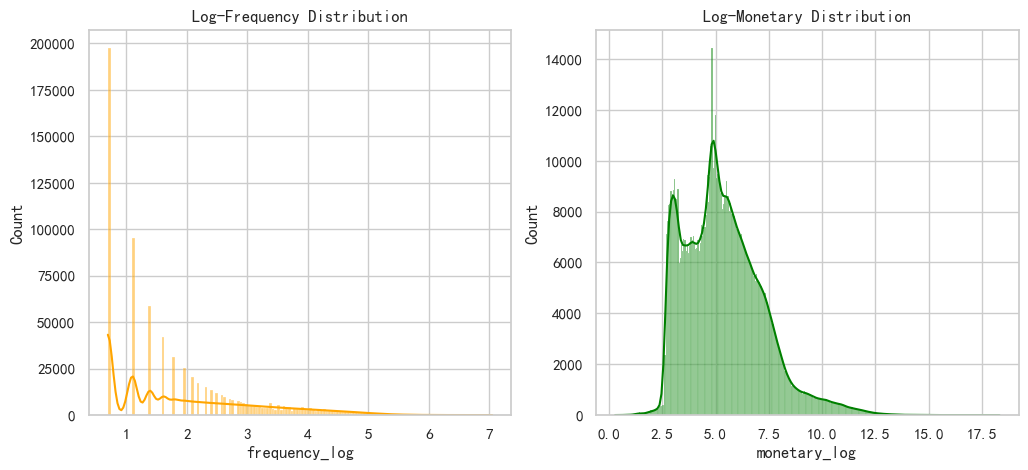

Scaled Data Stats:
       recency_days  frequency_log  monetary_log
count     738772.00      738772.00     738772.00
mean          -0.00           0.00         -0.00
std            1.00           1.00          1.00
min           -1.03          -1.02         -2.78
25%           -0.81          -1.02         -0.76
50%           -0.40          -0.26         -0.12
75%            0.57           0.65          0.60
max            2.75           4.24          7.08


In [7]:
# 4. Preprocessing

# Log Transformation for Skewed Features (frequency and monetary)
# Using log1p to handle any potential 0s safely
df_clean = df.copy()
df_clean['frequency_log'] = np.log1p(df_clean['frequency'])
df_clean['monetary_log'] = np.log1p(df_clean['monetary'])

# Visualize Log-Transformed Distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df_clean['frequency_log'], kde=True, ax=axes[0], color='orange')
axes[0].set_title('Log-Frequency Distribution')

sns.histplot(df_clean['monetary_log'], kde=True, ax=axes[1], color='green')
axes[1].set_title('Log-Monetary Distribution')
plt.show()

# Standardization (Z-score scaling)
scaler = StandardScaler()
features_to_scale = ['recency_days', 'frequency_log', 'monetary_log']
scaled_features = scaler.fit_transform(df_clean[features_to_scale])

# Create DF for stats checking
df_scaled = pd.DataFrame(scaled_features, columns=features_to_scale)
print("Scaled Data Stats:")
print(df_scaled.describe().round(2))

Calculating for K=[2, 3, 4, 5, 6, 7, 8] using sample size 15000...
K=2: SSE=21107.3, Silhouette=0.4454
K=3: SSE=13243.9, Silhouette=0.4227
K=4: SSE=10011.2, Silhouette=0.3798
K=5: SSE=8657.7, Silhouette=0.3424
K=6: SSE=7609.6, Silhouette=0.3626
K=7: SSE=6633.8, Silhouette=0.3306
K=8: SSE=5966.5, Silhouette=0.3228


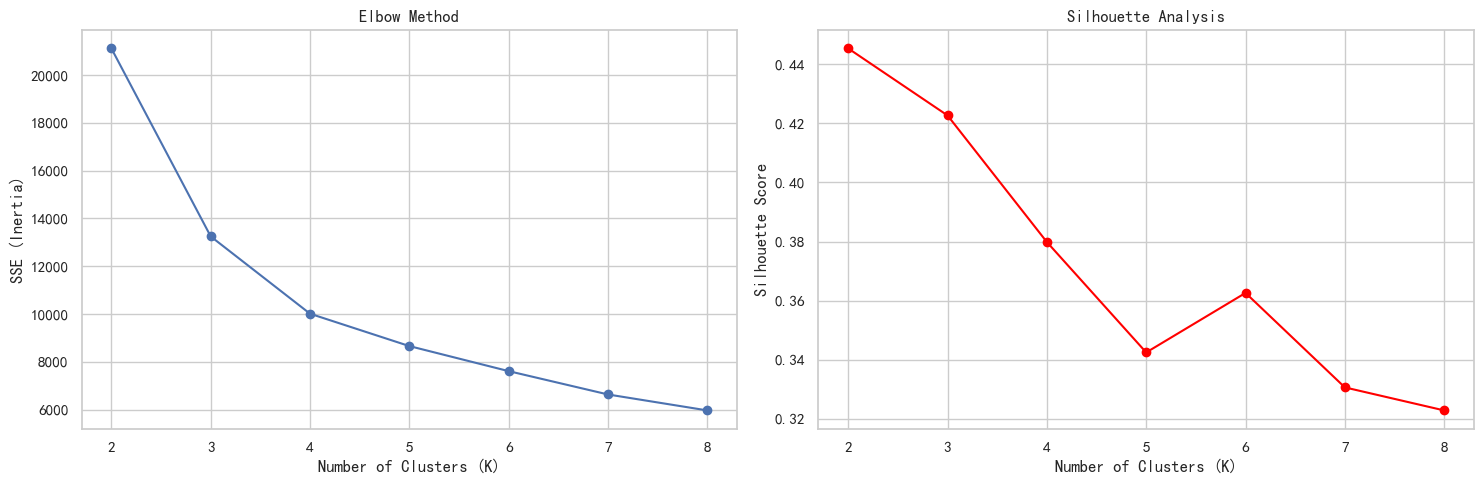

Recommended K based on max Silhouette Score: 2


In [8]:
# 5. K Selection (Elbow Method & Silhouette Score)

sse = []
silhouette_scores = []
k_range = range(2, 9)

# Use a sample for Silhouette Score calculation to save time (N=15k is sufficient for trend)
sample_size = 15000
if len(df_scaled) > sample_size:
    df_sample = df_scaled.sample(n=sample_size, random_state=42)
else:
    df_sample = df_scaled

print(f"Calculating for K={list(k_range)} using sample size {len(df_sample)}...")

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_sample)
    
    # Inertia (SSE)
    sse.append(kmeans.inertia_)
    
    # Silhouette Score
    score = silhouette_score(df_sample, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"K={k}: SSE={kmeans.inertia_:.1f}, Silhouette={score:.4f}")

# Plot Results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Elbow Plot
axes[0].plot(k_range, sse, marker='o')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('SSE (Inertia)')
axes[0].set_title('Elbow Method')

# Silhouette Plot
axes[1].plot(k_range, silhouette_scores, marker='o', color='red')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis')

plt.tight_layout()
plt.show()

# Recommendation
best_k = k_range[np.argmax(silhouette_scores)]
print(f"Recommended K based on max Silhouette Score: {best_k}")

In [9]:
# 6. Run K-Means Clustering

# Set K (you can manually override this based on the plots above)
SELECTED_K = best_k  # or manually set e.g., 4

print(f"Running K-Means with K={SELECTED_K} on full dataset...")
kmeans_final = KMeans(n_clusters=SELECTED_K, random_state=42, n_init=10)

# Fit on ALL data
df_clean['cluster'] = kmeans_final.fit_predict(scaled_features)

print("Cluster Counts:")
print(df_clean['cluster'].value_counts().sort_index())

Running K-Means with K=2 on full dataset...
Cluster Counts:
cluster
0    316589
1    422183
Name: count, dtype: int64


In [10]:
# 7. Visualization

# 7.1 3D Scatter Plot (Sampled)
plot_sample = df_clean.sample(n=min(5000, len(df_clean)), random_state=42)

fig = px.scatter_3d(
    plot_sample, 
    x='recency_days', 
    y='frequency', 
    z='monetary',
    color='cluster',
    title='3D View of Doctor Clusters (RFM)',
    opacity=0.7,
    size_max=10
)
fig.show()

# 7.2 Radar Chart of Center Points
# Calculate means for each cluster
cluster_means = df_clean.groupby('cluster')[['recency_days', 'frequency', 'monetary']].mean()

# Normalize means to 0-1 range for radar chart comparison
min_max_scaler = MinMaxScaler()
radar_data = pd.DataFrame(
    min_max_scaler.fit_transform(cluster_means), 
    columns=cluster_means.columns,
    index=cluster_means.index
)

# Create Radar Plot
categories = list(radar_data.columns)
fig = go.Figure()

for i in radar_data.index:
    fig.add_trace(go.Scatterpolar(
        r=radar_data.loc[i].values,
        theta=categories,
        fill='toself',
        name=f'Cluster {i}'
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=True,
  title="Cluster Center Characteristics (Normalized)"
)
fig.show()

In [11]:
# 8. Business Interpretation

# Calculate raw stats per cluster
summary_stats = df_clean.groupby('cluster').agg({
    'recency_days': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']
}).round(2)

print("Cluster Statistics (Raw Means):")
print(summary_stats)

print("\n--- Automated Interpretation ---")
global_means = df_clean[['recency_days', 'frequency', 'monetary']].mean()

for i in summary_stats.index:
    c_r = summary_stats.loc[i, ('recency_days', 'mean')]
    c_f = summary_stats.loc[i, ('frequency', 'mean')]
    c_m = summary_stats.loc[i, ('monetary', 'mean')]
    count = summary_stats.loc[i, ('monetary', 'count')]
    
    tags = []
    # Logic: Comparative to global mean
    if c_m > global_means['monetary'] * 1.5: tags.append("High Value")
    elif c_m < global_means['monetary'] * 0.6: tags.append("Low Value")
    
    if c_f > global_means['frequency'] * 1.5: tags.append("High Frequency")
    elif c_f < global_means['frequency'] * 0.6: tags.append("Low Frequency")
    
    if c_r < global_means['recency_days'] * 0.8: tags.append("Recent/Active")
    elif c_r > global_means['recency_days'] * 1.2: tags.append("At Risk/Inactive")
    
    desc = ", ".join(tags) if tags else "Average Behavior"
    print(f"Cluster {i} (N={count}): {desc}")

Cluster Statistics (Raw Means):
        recency_days frequency monetary        
                mean      mean     mean   count
cluster                                        
0             213.67     33.91  7713.85  316589
1             330.49      2.25   126.47  422183

--- Automated Interpretation ---
Cluster 0 (N=316589): High Value, High Frequency, Recent/Active
Cluster 1 (N=422183): Low Value, Low Frequency
